# CAB420 Assignment 1A Question 3: Template and Utilities Demo
Simon Denman (s.denman@qut.edu.au)

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1A, Question 3.

It also implements the SVM that you are to compare against when responsing to the question.

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale

These are provided to assist you in developing your solution.

In [1]:
#
# Utility functions for CAB420, Assignment 1A, Q3
# Author: Simon Denman (s.denman@qut.edu.au)
#

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from scipy.io import loadmat        # to load mat files
import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for colour conversion
import tensorflow as tf             # for bulk image resize
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical

# Load data for Q3
#  train_path: path to training data mat file
#  test_path:  path to testing data mat file
#
#  returns:    arrays for training and testing X and Y data
#
def load_data(train_path, test_path):

    # load files
    train = loadmat(train_path)
    test = loadmat(test_path)

    # transpose, such that dimensions are (sample, width, height, channels), and divide by 255.0
    train_X = np.transpose(train['train_X'], (3, 0, 1, 2)) / 255.0
    train_Y = train['train_Y']
    # change labels '10' to '0' for compatability with keras/tf. The label '10' denotes the digit '0'
    train_Y[train_Y == 10] = 0
    train_Y = np.reshape(train_Y, -1)

    # transpose, such that dimensions are (sample, width, height, channels), and divide by 255.0
    test_X = np.transpose(test['test_X'], (3, 0, 1, 2)) / 255.0
    test_Y = test['test_Y']
    # change labels '10' to '0' for compatability with keras/tf. The label '10' denotes the digit '0'
    test_Y[test_Y == 10] = 0
    test_Y = np.reshape(test_Y, -1)

    # return loaded data
    return train_X, train_Y, test_X, test_Y

# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Plot some images and their labels. Will plot the first 100 samples in a 10x10 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1)
        ax.imshow(x[i,:])
        ax.set_title(y[i])
        ax.axis('off')

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_BGR2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed.

### Data Loading

Load the data, and visualise images.

(1000, 32, 32, 3)
(1000,)
(10000, 32, 32, 3)
(10000,)


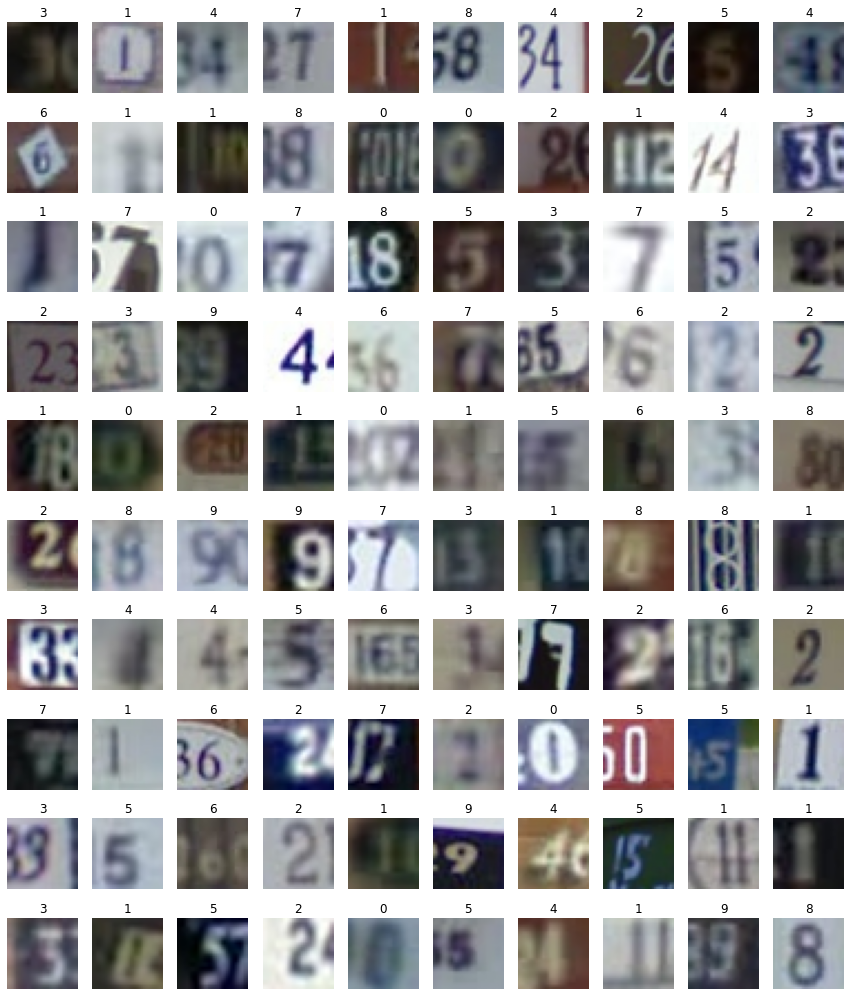

In [2]:
train_X, train_Y, test_X, test_Y = load_data('q3_train.mat', 'q3_test.mat')

# check shape of data
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

# visualise images as a sanity check
plot_images(train_X, train_Y)

### Vectorise Data

To train an SVM, each sample needs to be a vector rather than an image.

In [70]:
train_vector_X = vectorise(train_X)
test_vector_X = vectorise(test_X)
print(train_vector_X.shape)
print(test_vector_X.shape)

(1000, 3072)
(10000, 3072)


### Conversion and Resizing

You may wish to either:
* Resize images
* Convert images to grayscale

Two functions are provided to do this, and can be used in combination as shown below.

(1000, 28, 28, 1)


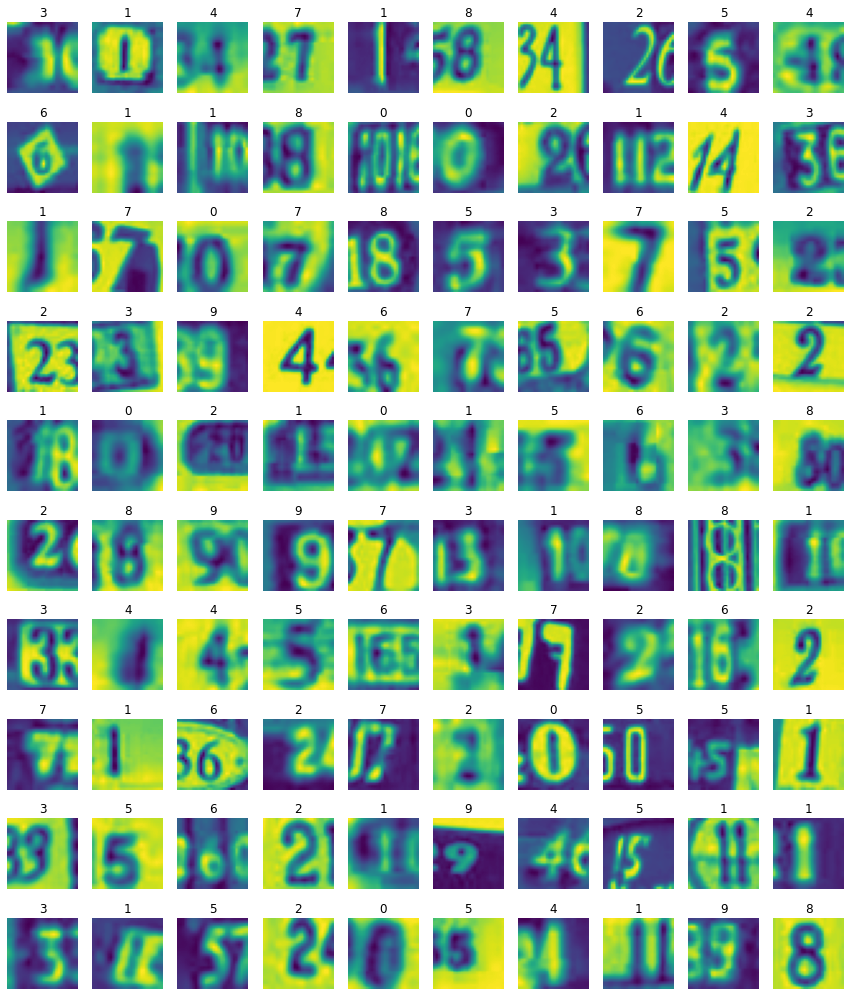

In [3]:
train_X_small = convert_to_grayscale(resize(train_X, (28, 28)))
print(train_X_small.shape)
plot_images(train_X_small, train_Y)

### Measuring Time

There are a lot of ways to measure time in python. A simple one is to use ``process_time`` within the ``time`` package. This will simply measure the ellapsed process time in seconds. We can use ths to measure individual parts of our code as follows:

In [72]:
# import process_time
from time import process_time

# get a start time
time_1 = process_time()

# do some stuff, in this case we'll just load some data
train_X, train_Y, test_X, test_Y = load_data('q3_train.mat', 'q3_test.mat')

# get the end time of our first lot of "stuff"
time_2 = process_time()

# do some other stuff
train_X_small = convert_to_grayscale(resize(train_X, (20, 20)))

# get the end time of our first lot of "stuff"
time_3 = process_time()

# the time it took to do "our stuff" is just the difference between the start and end times
print('Time to load data:   %f seconds' % (time_2 - time_1))
print('Time to resize data: %f seconds' % (time_3 - time_2))

Time to load data:   0.498079 seconds
Time to resize data: 0.031976 seconds


## Question 3

The following provides a starting point for your solution. It trains the SVM that you are to compare your trained DCNNs against, and measures the time taken to train this SVM, and to perform inference with the train and test sets.

This does not measure the performance of the SVM - you will need to implement this as part of your solution.

In [73]:
## supporting functions for eval
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model_SVM(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

Training Time: 3.470863
Inference Time (training set): 2.093167
Inference Time (testing set): 23.478283
              precision    recall  f1-score   support

           0       0.22      0.30      0.25       711
           1       0.37      0.50      0.43      1894
           2       0.39      0.36      0.37      1497
           3       0.36      0.33      0.34      1141
           4       0.34      0.31      0.32      1035
           5       0.35      0.32      0.34       892
           6       0.32      0.24      0.28       758
           7       0.38      0.30      0.34       789
           8       0.32      0.30      0.31       683
           9       0.38      0.29      0.33       600

    accuracy                           0.35     10000
   macro avg       0.34      0.33      0.33     10000
weighted avg       0.35      0.35      0.35     10000



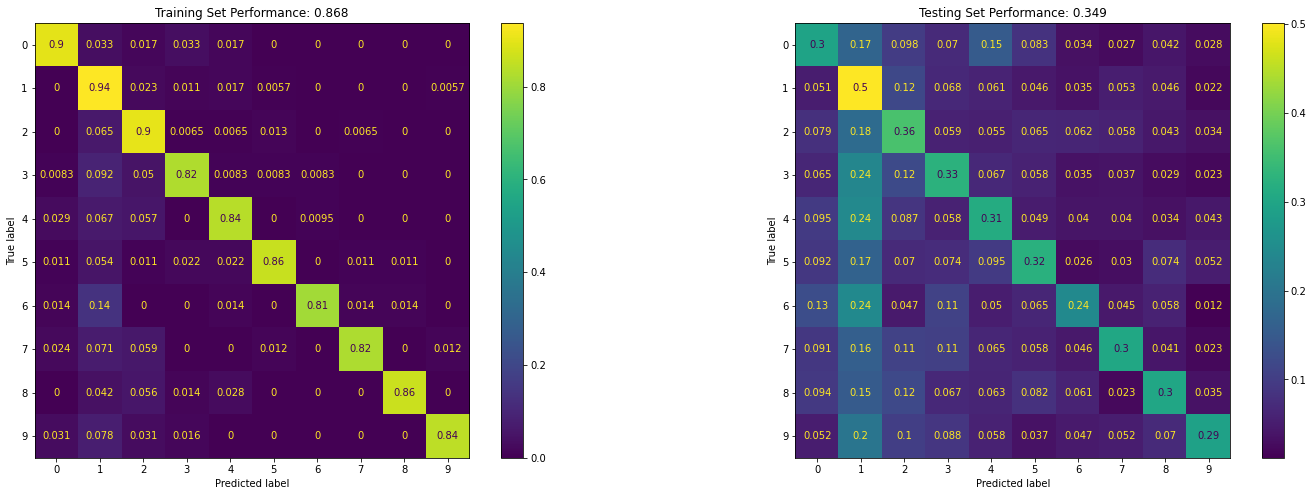

In [74]:
from sklearn.svm import SVC
from time import process_time

# load data
train_X, train_Y, test_X, test_Y = load_data('q3_train.mat', 'q3_test.mat')

# any resize, colour change, etc, would go here

# vectorise data
# make sure you vectorise the data you use with the DCNNs as input to the SVM for a fair comparison
train_vector_X = vectorise(train_X)
test_vector_X = vectorise(test_X)

# train the SVM
svm_train_start = process_time()
svm = SVC(C = 1.0, kernel = 'linear').fit(train_vector_X, train_Y)
svm_train_end = process_time()
train_predictions = svm.predict(train_vector_X)
svm_train_pred_end = process_time()
test_predictions = svm.predict(test_vector_X)
svm_test_pred_end = process_time()

svm_train_time = svm_train_end - svm_train_start
svm_inference_train_time = svm_train_pred_end - svm_train_end
svm_inference_test_time = svm_test_pred_end - svm_train_pred_end
print('Training Time: %f\nInference Time (training set): %f\nInference Time (testing set): %f' % \
      (svm_train_time, svm_inference_train_time, svm_inference_test_time))

# evaluate SVM
eval_model_SVM(svm, train_vector_X, train_Y, test_vector_X, test_Y)


# develop, evaluate and compare DCNNs



In [4]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 20])    

    ax = fig.add_subplot(1, 1, 1)    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)

    fig = plt.figure(figsize=[10, 5])    

    ax = fig.add_subplot(1, 1, 1)    
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()

    print(classification_report(gt_idx, indexes))

In [5]:
### DCNN without data aug
model = keras.models.load_model('models/resnet_v1_MNIST_medium.h5')
model.summary()

Model: "medium_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_109 (Conv2D)            (None, 28, 28, 8)    80          ['img[0][0]']                    
                                                                                                  
 batch_normalization_95 (BatchN  (None, 28, 28, 8)   32          ['conv2d_109[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_95 (Activation)     (None, 28, 28, 8)    0           ['batch_normalizat

In [6]:
outputs = layers.Dense(10, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_109 (Conv2D)            (None, 28, 28, 8)    80          ['img[0][0]']                    
                                                                                                  
 batch_normalization_95 (BatchN  (None, 28, 28, 8)   32          ['conv2d_109[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_95 (Activation)     (None, 28, 28, 8)    0           ['batch_normalization_95[0][0

In [14]:
## resizing data
res_train_X =  convert_to_grayscale(resize(train_X, (28, 28)))
res_test_X =  convert_to_grayscale(resize(test_X, (28, 28)))
train_y = to_categorical(train_Y, 10)
test_y = to_categorical(test_Y, 10)

print(train_y)
print(test_y)

new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(res_train_X, train_y,
                        batch_size=128,
                        epochs=20,
                        validation_data=(res_test_X, test_y))

Epoch 1/20
8/8 [==============================] - 31s 2s/step - loss: 1.3525 - accuracy: 0.5870 - val_loss: 1.8182 - val_accuracy: 0.3903
Epoch 2/20
8/8 [==============================] - 14s 2s/step - loss: 1.3274 - accuracy: 0.5980 - val_loss: 1.7682 - val_accuracy: 0.4197
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 1.3231 - accuracy: 0.5910 - val_loss: 1.7761 - val_accuracy: 0.4174
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 1.2891 - accuracy: 0.5900 - val_loss: 1.7254 - val_accuracy: 0.4262
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 1.2744 - accuracy: 0.6060 - val_loss: 1.8272 - val_accuracy: 0.3971
Epoch 6/20
8/8 [==============================] - 14s 2s/step - loss: 1.2610 - accuracy: 0.6080 - val_loss: 1.7543 - val_accuracy: 0.4221
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 1.2539 - accuracy: 0.6260 - val_loss: 1.8271 - val_accuracy: 0.3976
Epoch 8/20
8/8 [==================

313/313 [==============================] - 20s 58ms/step
              precision    recall  f1-score   support

           0       0.44      0.14      0.21       711
           1       0.62      0.75      0.68      1894
           2       0.75      0.54      0.63      1497
           3       0.41      0.23      0.30      1141
           4       0.43      0.72      0.54      1035
           5       0.50      0.61      0.55       892
           6       0.26      0.44      0.32       758
           7       0.63      0.58      0.60       789
           8       0.36      0.34      0.35       683
           9       0.31      0.13      0.19       600

    accuracy                           0.50     10000
   macro avg       0.47      0.45      0.44     10000
weighted avg       0.51      0.50      0.48     10000



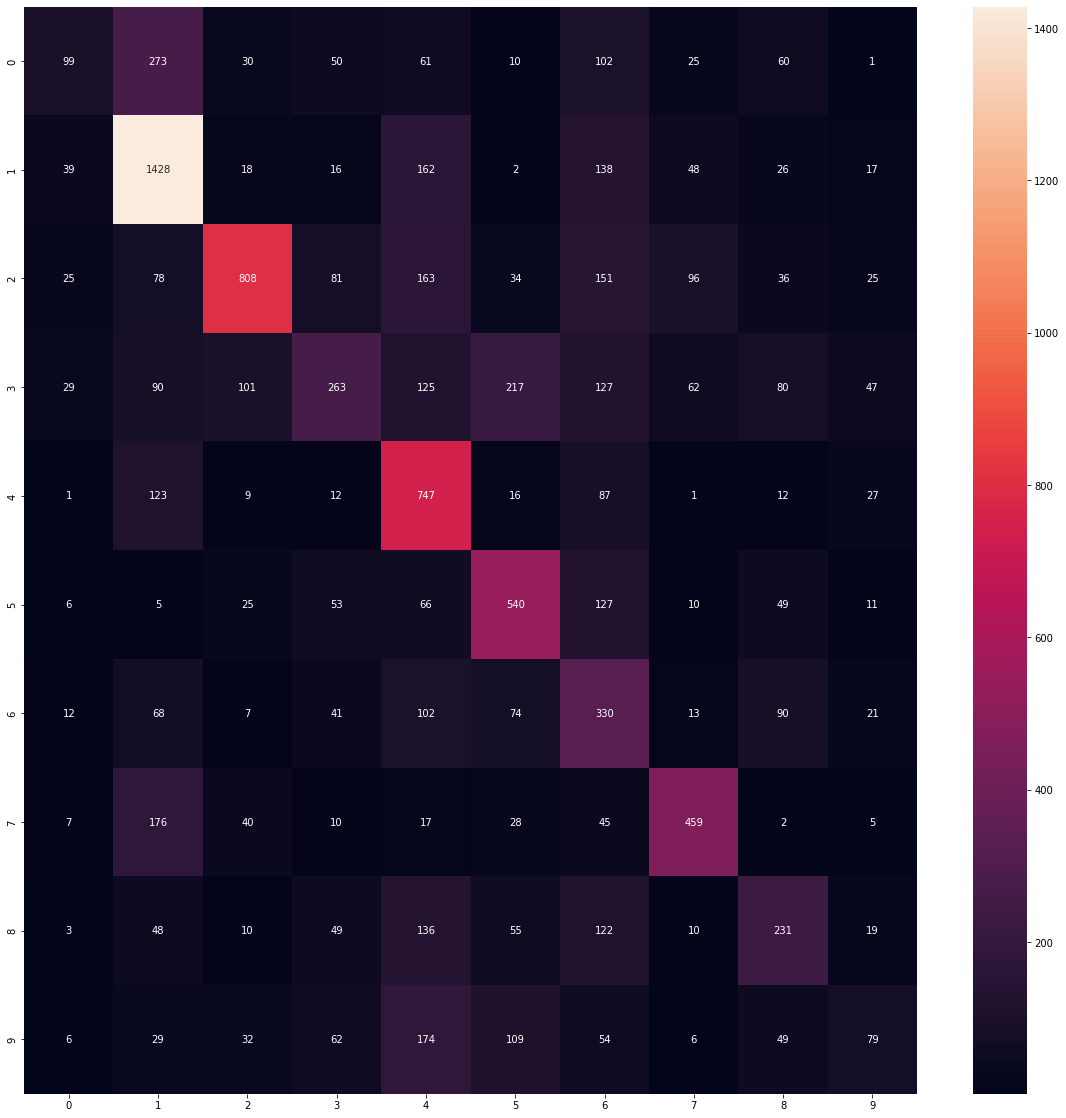

<Figure size 720x576 with 0 Axes>

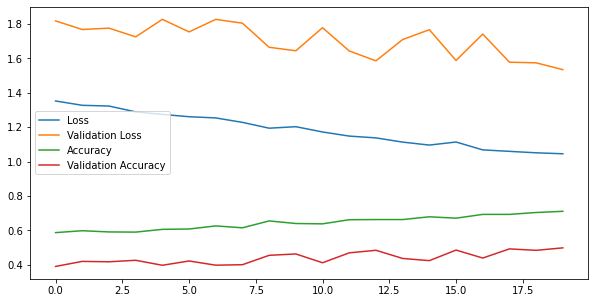

In [15]:
eval_model(new_model, history.history, res_train_X, train_y, res_test_X, test_y)